# CS 590 Deep Learning : Multi-Label Chest X-Ray Classification for Long tailed diseases

# Imports

In [1]:
### Imports

# This code section imports necessary libraries, sets up the environment, 
# and prepares for ensemble learning


import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import gc
import warnings
warnings.filterwarnings("ignore")
import sys
import time
####
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
####
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim
import torchvision.transforms as transforms
import torchvision
##
from fastprogress import master_bar, progress_bar
from PIL import Image
gc.collect()

0

In [2]:
print(time.strftime("%H:%M:%S",time.localtime()))

16:45:35


## Define directories

In [3]:
path='/kaggle/input/chexpert-v10-small/'
out='/kaggle/working/'

In [4]:
# Reads train and validation data from CSV files, extracts patient
# and study information from file paths, and stores it in DataFrames.

chestxrays_root = Path(path)
data_path = chestxrays_root

full_train_df = pd.read_csv(path+'CheXpert-v1.0-small/train.csv')
full_valid_df = pd.read_csv(path+'CheXpert-v1.0-small/valid.csv')

full_train_df['patient'] = full_train_df.Path.str.split('/',n=3,expand=True)[2]
full_train_df['study'] = full_train_df.Path.str.split('/',n=4,expand=True)[3]

full_valid_df['patient'] = full_valid_df.Path.str.split('/',n=3,expand=True)[2]
full_valid_df['study'] = full_valid_df.Path.str.split('/',n=4,expand=True)[3]

print("Train Data : ",len(full_train_df))

full_train_df.head()

Train Data :  223414


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient00003,study1


## Input Data Plots
### Analyze Input Data

In [5]:
# Iterates through a list of labels, calculates counts for specific values (-1, 0, 1, and NaN)
# in the training dataset, and stores the results in a DataFrame.


cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices']

data_df = []

for i in cols:
    minusOneVal = sum(np.where(full_train_df[i] == -1,1,0))
    oneVal = sum(np.where(full_train_df[i] == 1,1,0))
    zeroVal = sum(np.where(full_train_df[i] == 0,1,0))
    #nanVal = sum(np.where(full_train_df[i] == np.NaN ,1,0))
    nanVal = full_train_df[i].isnull().sum()
    data_df.append([i,minusOneVal,oneVal,zeroVal,nanVal])
    
data_df = pd.DataFrame(data_df)
data_df.columns = ['Label','minusOneVal','oneVal','zeroVal','nanVal']
data_df

,Label,minusOneVal,oneVal,zeroVal,nanVal
0,No Finding,0,22381,0,201033
1,Enlarged Cardiomediastinum,12403,10798,21638,178575
2,Cardiomegaly,8087,27000,11116,177211
3,Lung Opacity,5598,105581,6599,105636
4,Lung Lesion,1488,9186,1270,211470
5,Edema,12984,52246,20726,137458
6,Consolidation,27742,14783,28097,152792
7,Pneumonia,18770,6039,2799,195806
8,Atelectasis,33739,33376,1328,154971
9,Pneumothorax,3145,19448,56341,144480


### Plot input Data

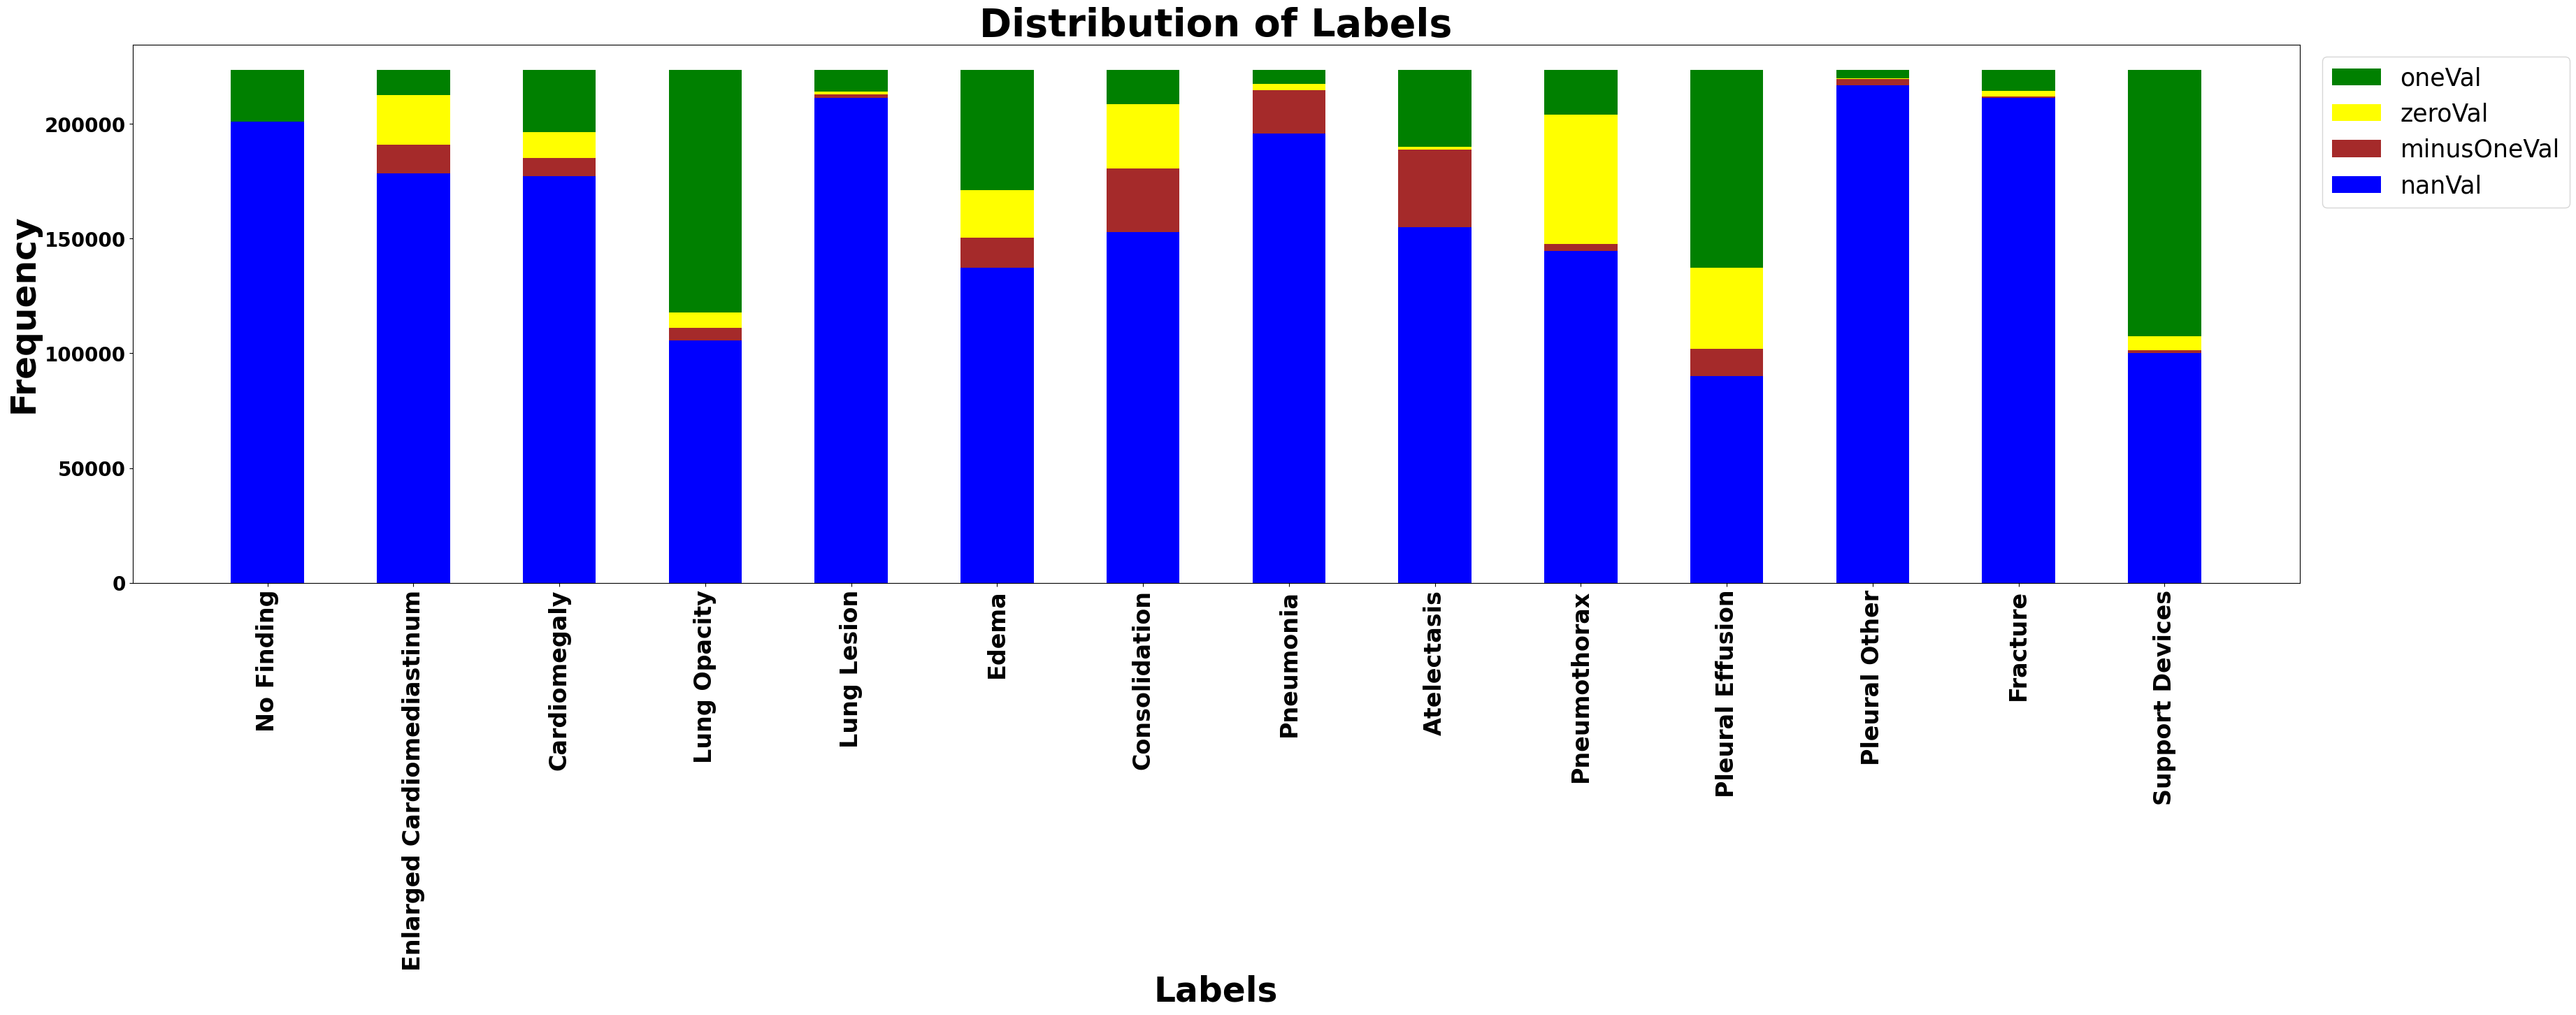

In [6]:
# Generates a bar chart displaying the distribution of
# label values, using different colors to represent each value.

plt.figure(figsize=(40,10))
Label = data_df['Label']
nanVal = data_df['nanVal']
minusOneVal = data_df['minusOneVal']
zeroVal = data_df['zeroVal']
oneVal = data_df['oneVal']

ind = [x for x, _ in enumerate(Label)]

plt.bar(Label, oneVal, width=0.5, label='oneVal', color='green', bottom=zeroVal+minusOneVal+nanVal)
plt.bar(Label, zeroVal, width=0.5, label='zeroVal', color='yellow', bottom=minusOneVal+nanVal)
plt.bar(Label, minusOneVal, width=0.5, label='minusOneVal', color='brown',bottom=nanVal)
plt.bar(Label, nanVal, width=0.5, label='nanVal', color='blue')

plt.yticks(fontsize=20,fontweight='bold')

plt.xticks(ind, Label,fontsize=24,fontweight='bold',rotation=90)
plt.ylabel("Frequency",fontsize=35,fontweight='bold')
plt.xlabel("Labels",fontsize=35,fontweight='bold')
plt.legend(bbox_to_anchor=(1.005, 1),fontsize=25)
#plt.legend(bbox_to_anchor=(1.005, 1))
plt.title("Distribution of Labels",fontsize=40, fontweight='bold')

plt.show()

## Handling Uncertainities - U_one and U_zero

In [ ]:
# Since this model is used as a first pass for chest x-ray diagnosis, 
# false negative has higher cost and all uncertainties were 
# consdiered as positive (replaced -1 by 1)

In [7]:
u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']

full_train_df['Cardiomegaly'] = full_train_df['Cardiomegaly'].replace(-1,0)
full_train_df['Consolidation'] = full_train_df['Consolidation'].replace(-1,0)
full_train_df['Pleural Effusion'] = full_train_df['Pleural Effusion'].replace(-1,0)

full_train_df['Atelectasis'] = full_train_df['Atelectasis'].replace(-1,1)
full_train_df['Edema'] = full_train_df['Edema'].replace(-1,1)
full_train_df = full_train_df.replace(-1,np.nan)
full_train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,0.0,1.0,NaN,...,0.0,NaN,1.0,NaN,0.0,NaN,1.0,NaN,patient00002,study2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002,study1
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient00003,study1


In [8]:
#  Drops 'patient' and 'study' columns from full_train_df, then prints its size.

full_train_df = full_train_df.drop(['patient', 'study'],axis=1)
print(full_train_df.Path.size)

223414


## Get Labels

In [9]:
LABELS = full_train_df.columns[5:]
LABELS

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

# Split Test & Train

In [10]:
# Splits data into training and validation sets, 
# deletes unnecessary DataFrames, and prints their sizes.

train_data, val_data = train_test_split(full_train_df, test_size=0.20, random_state=2021)
del full_train_df
del full_valid_df
gc.collect()
print(train_data.Path.size)
print(val_data.Path.size)

178731
44683


# Define Models

<ol>
<li> Custom Net 
<li> Densenet121 
<li> Resnet50 - Freeze first 6 layers
<li>  Vgg16 - Freeze first 6 layers
<ol>
    

### Custom Model CNN

In [11]:
# CustomNet is a neural network with convolutional layers followed by max-pooling, ReLU activation, 
# and a final linear layer with sigmoid activation for multi-label classification.

class CustomNet(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):
        super().__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3), # inp (3, 512, 512)
            nn.Conv2d(8, 16, 3),
            nn.MaxPool2d(2),
            nn.ReLU() # op (16, 256, 256)
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(16, 32, 5), # inp (16, 256, 256)
            nn.Conv2d(32, 32, 3),
            nn.MaxPool2d(4),
            nn.ReLU() # op (32, 64, 64)
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3), # inp (32, 64, 64)
            nn.Conv2d(64, 64, 5),
            nn.MaxPool2d(2),
            nn.ReLU() # op (64, 32, 32)
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(64, 128, 5), # inp (64, 32, 32)
            nn.Conv2d(128, 128, 3),
            nn.MaxPool2d(2),
            nn.ReLU() # op (128, 16, 16)
        )
        #self.Lin1 = nn.Linear(15488, 15)
        self.Lin1 = nn.Sequential(nn.Linear(512, 14), nn.Sigmoid())        
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.Lin1(x)
       
        
        return x

### Pre Trained Models

The provided code defines three pretrained models for ensemble learning. The DenseNet121, ResNet50, and VGG16 models are adapted for multi-label classification tasks by replacing their final layers with new layers that output predictions for 14 classes and applying a sigmoid activation function for each class. These models are designed to be used as components in an ensemble learning approach for disease classification.

In [12]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):

        super().__init__()
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features            
        self.net.classifier = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)
#
class ResNet50(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):

        super().__init__()
        self.net = torchvision.models.resnet50(pretrained=is_trained)
        # Get the input dimension of last layer
        #kernel_count = self.net.classifier.in_features

        ## Freeze first 8 layers
        ct = 0
        for child in self.net.children():
            ct += 1
            if ct < 9:
                for param in child.parameters():
                    param.requires_grad = False
                
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 14),nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)
    
#
class Vgg16(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):

        super().__init__()
        self.net = torchvision.models.vgg16(pretrained=is_trained)
        
        ## Freeze first 6 layers
        ct = 0
        for child in self.net.children():
            ct += 1
            if ct < 7:
                for param in child.parameters():
                    param.requires_grad = False

        # Newly created modules have require_grad=True by default
        num_features = self.net.classifier[6].in_features
        features = list(self.net.classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 4 outputs
        self.net.classifier = nn.Sequential(*features, nn.Sigmoid()) # Replace the model classifier
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)


## Create Dataset

In [13]:
# ChestXrayDataset is a custom PyTorch dataset for chest X-ray images, handling image loading,
# resizing, and label extraction for multi-label classification tasks.


class ChestXrayDataset(Dataset):
    
    def __init__(self, folder_dir, dataframe, image_size, normalization):
        """
        folder_dir: str
            folder contains all images
        dataframe: pandas.DataFrame
            dataframe contains all information of images
        image_size: int
            image size to rescale
        normalization: bool
            whether applying normalization with mean and std from ImageNet or not
        """
        self.image_paths = [] # List of image paths
        self.image_labels = [] # List of image labels
        
        # Define list of image transformations
        image_transformation = [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ]
        
        self.image_transformation = transforms.Compose(image_transformation)
        
        # Get all image paths and image labels from dataframe
        for index, row in dataframe.iterrows():
            image_path = os.path.join(folder_dir, row.Path)
            self.image_paths.append(image_path)
            if len(row) < 14:
                labels = [0] * 14
            else:
                labels = []
                for col in row[5:]:
                    if col == 1:
                        labels.append(1)
                    else:
                        labels.append(0)
            self.image_labels.append(labels)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Read image at index and convert to torch Tensor
        """
        
        # Read image
        image_path = self.image_paths[index]
        image_data = Image.open(image_path).convert("RGB") # Convert image to RGB channels
        
        # Resize and convert image to torch tensor 
        image_data = self.image_transformation(image_data)
        
        return image_data, torch.FloatTensor(self.image_labels[index])

## Training Parameters

In [14]:
IMAGE_SIZE = 224                              # Image size (224x224)
BATCH_SIZE = 96                              
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 5 ##100                              # Maximum number of training epochs

## Training Data

### Train Loader

In [15]:
# Sets the data path, creates a training dataset with image normalization, 
# and loads it into a dataloader.

# The loop prints the size of data and labels for the first batch.

my_data_path = path
train_dataset = ChestXrayDataset(my_data_path, train_data, IMAGE_SIZE, True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
for data, label in train_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([96, 3, 224, 224])
torch.Size([96, 14])


### Validation Loader

In [16]:
val_dataset = ChestXrayDataset(my_data_path, val_data, IMAGE_SIZE, True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [17]:
del train_data
del val_data
del train_dataset
del val_dataset
gc.collect()

0

## Set Device

Assigns "cuda" to the device if a GPU is available; otherwise, it uses the CPU. Clears GPU cache if using CUDA.

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache()
device

'cuda'

## Evaluation Metrics

### AUROC
### Accuracy
### f1 score
### Precision and Recall

In [20]:
def multi_label_auroc(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    auroc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        try:
            auroc.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
        except ValueError:
            pass
    return auroc

def multi_label_accuracy(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    acc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        acc.append(accuracy_score(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0)))
    return acc

def multi_label_f1(y_gt, y_pred):
    """ Calculate f1 for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    f1_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        f1_out.append(f1_score(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0)))
    return f1_out


def multi_label_precision_recall(y_gt, y_pred):
    """ Calculate precision for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        precision of each class
    """
    precision_out = []
    recall_out = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        p = precision_recall_fscore_support(gt_np[:, i], np.where(pred_np[:, i]>=0.5,1,0),average='binary')
        precision_out.append(p[0])
        recall_out.append(p[1])
    return precision_out,recall_out

**Training Function**

In [21]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
   
    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        #pred = torch.LongTensor(pred)
        loss = loss_criteria(pred, labels)
        #print("loss is ",loss)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        #mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

**Evaluating Function**

In [22]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """

    # Switch model to evaluation mode
    model.eval()

    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            #mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    val_loss_mean = val_loss/len(val_loader)
    auroc_mean = np.nanmean(np.array(multi_label_auroc(out_gt, out_pred)))
    acc_mean = np.nanmean(np.array(multi_label_accuracy(out_gt, out_pred)))
    f1_mean = np.nanmean(np.array(multi_label_f1(out_gt, out_pred)))
    
    return val_loss_mean,auroc_mean,acc_mean,f1_mean

**Define Optimizer**

In [23]:
def get_opt(modeltxt,model):
    
    if modeltxt == "DenseNet121":
        return optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
    
    if modeltxt == "ResNet50":
        return optim.Adam(model.parameters())
    
    if modeltxt == "Vgg16":
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    if modeltxt == "CustomNet":
        return optim.Adam(model.parameters())

# Train Model

The trainModel function trains a given model, computes its loss, and evaluates its performance over several epochs. It also handlesearly stopping. The function returns the best AUROC score, accuracy, F1 score, and the best trained model.

In [24]:
def trainModel(modelname,loss_criteria,modeltxt):
    model = modelname(num_classes=len(LABELS),is_trained=True).to(device)

    optimizer = get_opt(modeltxt,model)
    # Learning rate will be reduced automatically during training
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR,
                                                        patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)
    best_score = 0
    best_score_acc = 0
    best_score_f1 = 0
    
    model_path = out+modeltxt+".pth"
    out_path = out+modeltxt+"_running.csv"
    training_losses = []
    validation_losses = []
    validation_score = []
    validation_acc = []
    validation_f1 = []


    # Config progress bar
    mb = master_bar(range(MAX_EPOCHS))
    mb.names = ['Train loss', 'Val loss', 'AUROC', 'Accuracy', 'f1 score']
    x = []

    nonimproved_epoch = 0
    start_time = time.time()
    cnt = 1

    # Training each epoch
    for epoch in mb:
        #break
        mb.main_bar.comment = f'Best AUROC score: {best_score}'
        x.append(epoch)

        # Training
        train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
        mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
        training_losses.append(train_loss)

        # Evaluating
        val_loss, new_score, new_score_acc, new_score_f1 = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)

        validation_losses.append(val_loss)
        validation_score.append(new_score)
        validation_acc.append(new_score_acc)
        validation_f1.append(new_score_f1)

        gc.collect()
        # Update learning rate
        lr_scheduler.step(new_score)

        diff = np.round(time.time() - start_time)
        pd.DataFrame([[epoch,modeltxt,best_score,new_score,diff]]).to_csv(out_path,index=False,mode='a',header=False)
        # Save model
        t2 = 4
        if modeltxt == 'DenseNet121':
            t2 = 6
        if best_score < new_score:
            #mb.write(f"Improve AUROC from {best_score} to {new_score}")    
            best_score = new_score
            best_score_acc = new_score_acc
            best_score_f1 = new_score_f1
            nonimproved_epoch = 0
            best_model = model
            torch.save({"model": model.state_dict(), 
                        "optimizer": optimizer.state_dict(), 
                        "best_score": best_score, 
                        "epoch": epoch, 
                        "lr_scheduler": lr_scheduler.state_dict()}, model_path)
        else: 
            nonimproved_epoch += 1
        if nonimproved_epoch > 5:
            break
            print("Early stopping")
        if time.time() - start_time > 3600*t2:
            break
            print("Out of time")

    
    return best_score,best_score_acc,best_score_f1,best_model
       

## Set Models to Train

In [25]:
model_list = [CustomNet,DenseNet121,ResNet50,Vgg16]
mName_list = ['CustomNet','DenseNet121','ResNet50','Vgg16']

## Train Models in a Loop

This code segment iterates through a list of models, trains each model, and stores their best AUROC score, accuracy, and F1 score along with the corresponding model names in eval_df_train.

In [26]:
eval_df_train = []
for m in model_list:
    mName = m().__class__.__name__
    print("Processing Model ",mName)
    globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"],globals()[f"best_model_{mName}"] = trainModel(modelname=m,loss_criteria=nn.BCELoss(),modeltxt=mName)
    #
    eval_df_train.append([mName,globals()[f"best_score_{mName}"],globals()[f"best_score_acc_{mName}"],globals()[f"best_score_f1_{mName}"]])

Processing Model  CustomNet


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


Processing Model  DenseNet121


100%|██████████| 30.8M/30.8M [00:00<00:00, 72.8MB/s]


Processing Model  ResNet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.6MB/s]


Processing Model  Vgg16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.9MB/s] 


## Evaluation Results

This code segment converts the list of model evaluation results into a DataFrame, sets column names, saves it as a CSV file, and displays the resulting DataFrame.

In [27]:
eval_df_train=pd.DataFrame(eval_df_train)
eval_df_train.columns = ['Model Name','AUROC', 'Accuracy', 'f1 Score']
eval_df_train.to_csv(out+"eval_df_train.csv",index=False)
eval_df_train

,Model Name,AUROC,Accuracy,f1 Score
0,CustomNet,0.730277,0.859151,0.234112
1,DenseNet121,0.770519,0.868963,0.262854
2,ResNet50,0.705934,0.852066,0.167341
3,Vgg16,0.662054,0.847297,0.164762


## Best model Parameters

The code defines functions to count the total and trainable parameters in a model. It then iterates through a list of models, calculates and stores their total and trainable parameters, and presents the information in a DataFrame.

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters_all(model):
    return sum(p.numel() for p in model.parameters())

param_list = []
i = 0
for model in model_list:
    modelName = model().__class__.__name__
    num_params_all = count_parameters_all(model())
    num_params = count_parameters(model())
    param_list.append([modelName,num_params_all,num_params])

param_list=pd.DataFrame(param_list)
param_list.columns = ['Model Name','Total Parameters','Trainable Parameters']
param_list

,Model Name,Total Parameters,Trainable Parameters
0,CustomNet,504126,504126
1,DenseNet121,6968206,6968206
2,ResNet50,23772110,264078
3,Vgg16,134317902,57358


This code defines a function to print and summarize the trainable parameters in a model using the PrettyTable library. It displays the module names and their corresponding parameter counts and provides the total trainable parameters.

In [29]:
from prettytable import PrettyTable

def count_parameters_pretty(model):
    print(model.__class__.__name__)
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    k = f"Total Trainable Params: {total_params}"
    return k

out1=count_parameters_pretty(best_model_CustomNet)

CustomNet
+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| ConvLayer1.0.weight |    216     |
|  ConvLayer1.0.bias  |     8      |
| ConvLayer1.1.weight |    1152    |
|  ConvLayer1.1.bias  |     16     |
| ConvLayer2.0.weight |   12800    |
|  ConvLayer2.0.bias  |     32     |
| ConvLayer2.1.weight |    9216    |
|  ConvLayer2.1.bias  |     32     |
| ConvLayer3.0.weight |   18432    |
|  ConvLayer3.0.bias  |     64     |
| ConvLayer3.1.weight |   102400   |
|  ConvLayer3.1.bias  |     64     |
| ConvLayer4.0.weight |   204800   |
|  ConvLayer4.0.bias  |    128     |
| ConvLayer4.1.weight |   147456   |
|  ConvLayer4.1.bias  |    128     |
|    Lin1.0.weight    |    7168    |
|     Lin1.0.bias     |     14     |
+---------------------+------------+
Total Trainable Params: 504126


In [30]:
# Deletes training and validation data loaders and performs garbage collection.

del train_dataloader
del val_dataloader
gc.collect()

44725

# TESTING AND PREDICTION - Based on Unseen Test Data

In [31]:
full_test_df = pd.read_csv(path+'CheXpert-v1.0-small/valid.csv')

## Test Data Distribution

In [32]:
cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices']

data_df = []

for i in cols:
    minusOneVal = sum(np.where(full_test_df[i] == -1,1,0))
    oneVal = sum(np.where(full_test_df[i] == 1,1,0))
    zeroVal = sum(np.where(full_test_df[i] == 0,1,0))
    nanVal = full_test_df[i].isnull().sum()
    data_df.append([i,minusOneVal,oneVal,zeroVal,nanVal])
    
data_df = pd.DataFrame(data_df)

data_df.columns = ['Label','minusOneVal','oneVal','zeroVal','nanVal']
data_df

,Label,minusOneVal,oneVal,zeroVal,nanVal
0,No Finding,0,38,196,0
1,Enlarged Cardiomediastinum,0,109,125,0
2,Cardiomegaly,0,68,166,0
3,Lung Opacity,0,126,108,0
4,Lung Lesion,0,1,233,0
5,Edema,0,45,189,0
6,Consolidation,0,33,201,0
7,Pneumonia,0,8,226,0
8,Atelectasis,0,80,154,0
9,Pneumothorax,0,8,226,0


## Test Data Plot

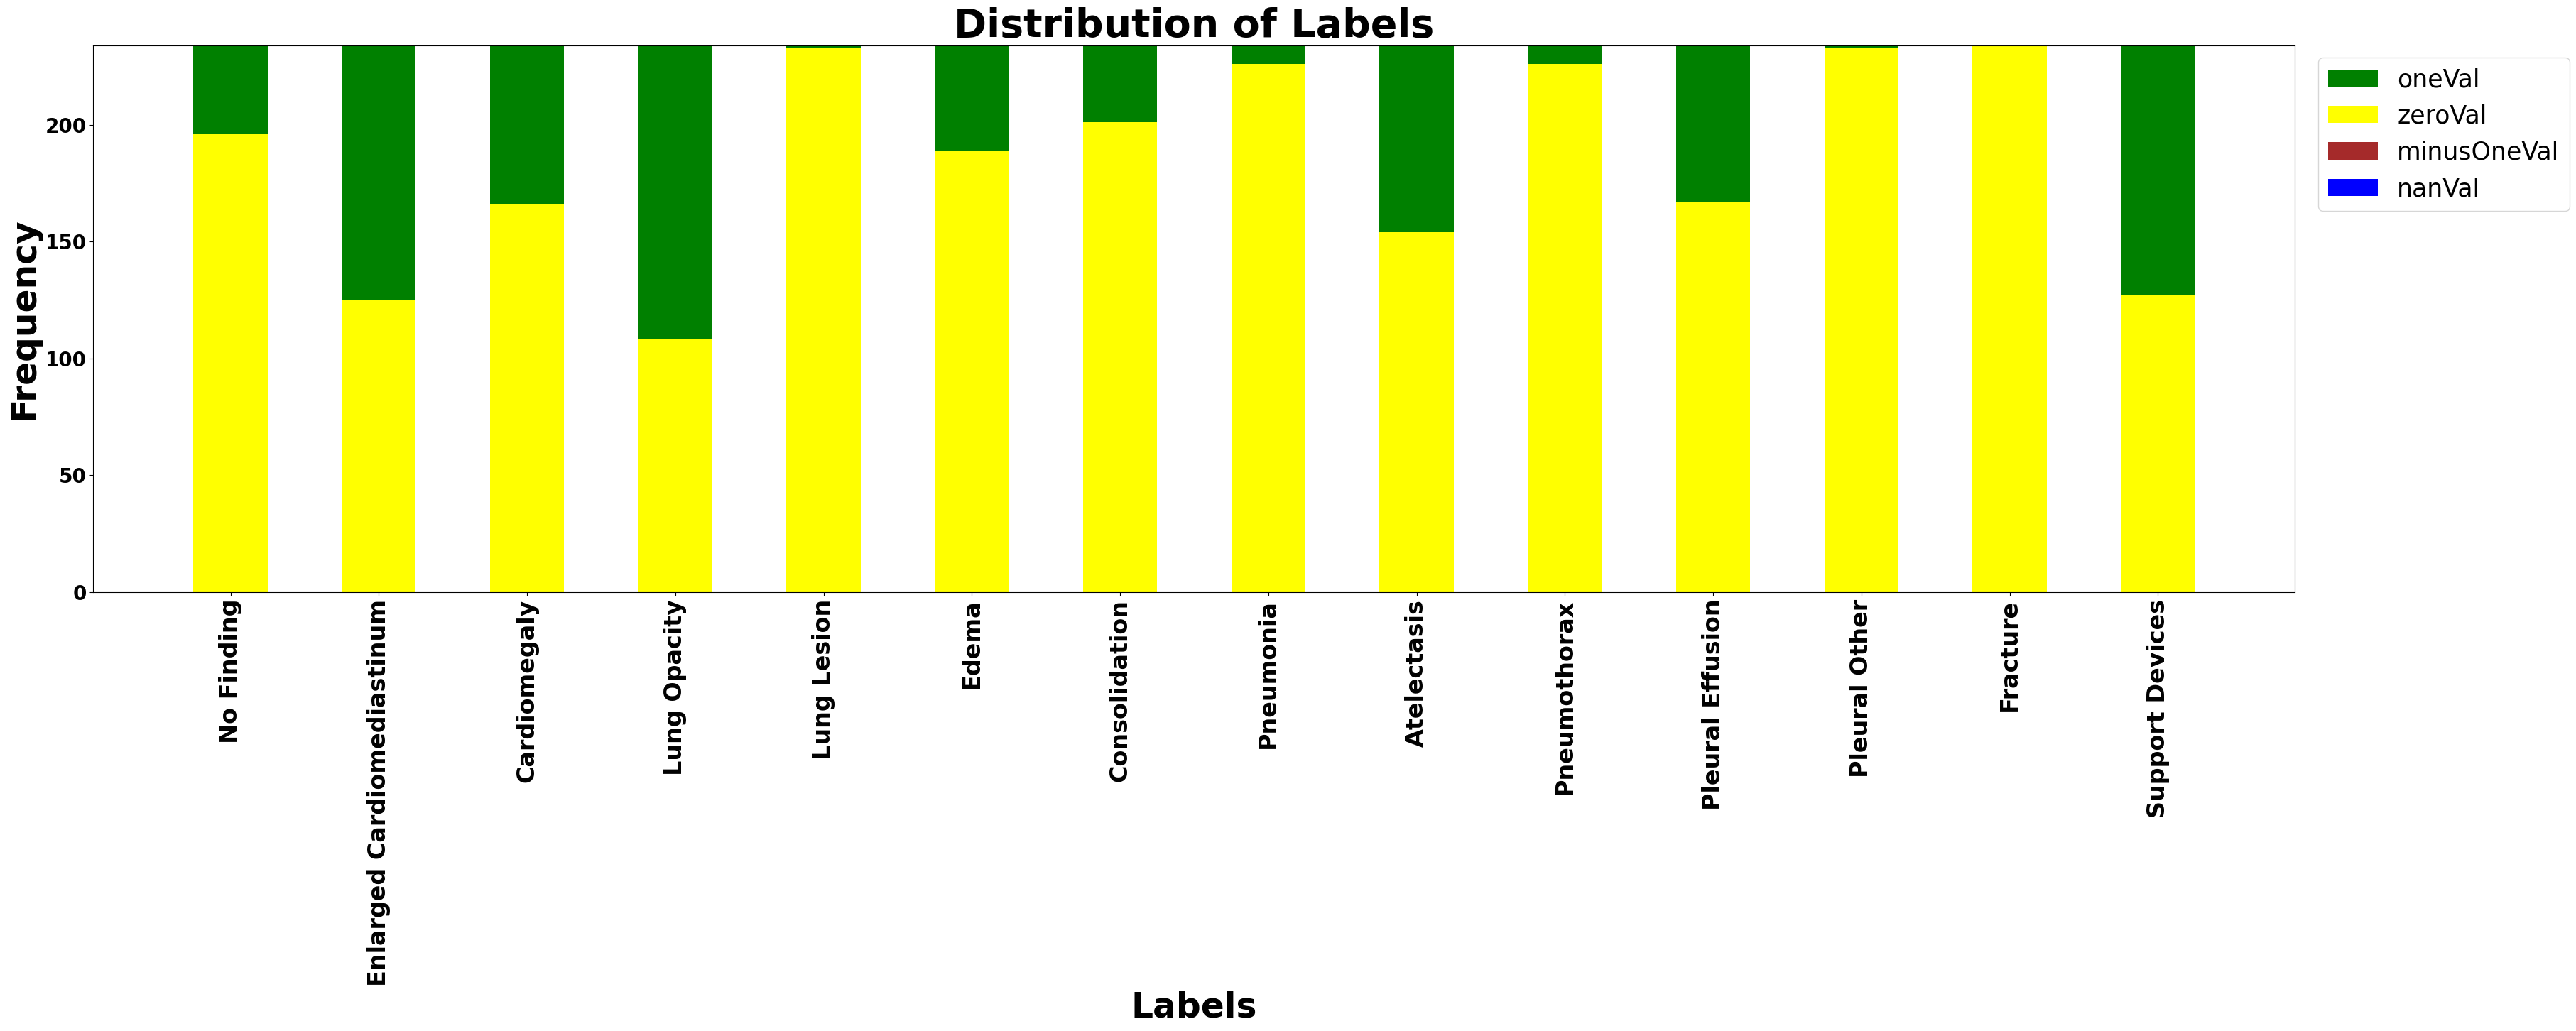

In [33]:
plt.figure(figsize=(40,10))
Label = data_df['Label']
nanVal = data_df['nanVal']
minusOneVal = data_df['minusOneVal']
zeroVal = data_df['zeroVal']
oneVal = data_df['oneVal']

ind = [x for x, _ in enumerate(Label)]

plt.bar(Label, oneVal, width=0.5, label='oneVal', color='green', bottom=zeroVal+minusOneVal+nanVal)
plt.bar(Label, zeroVal, width=0.5, label='zeroVal', color='yellow', bottom=minusOneVal+nanVal)
plt.bar(Label, minusOneVal, width=0.5, label='minusOneVal', color='brown',bottom=nanVal)
plt.bar(Label, nanVal, width=0.5, label='nanVal', color='blue')

plt.yticks(fontsize=20,fontweight='bold')

plt.xticks(ind, Label,fontsize=24,fontweight='bold',rotation=90)
plt.ylabel("Frequency",fontsize=35,fontweight='bold')
plt.xlabel("Labels",fontsize=35,fontweight='bold')
plt.legend(bbox_to_anchor=(1.005, 1),fontsize=25)
#plt.legend(bbox_to_anchor=(1.005, 1))
plt.title("Distribution of Labels",fontsize=40, fontweight='bold')

plt.show()

In [34]:
full_test_df.size

4446

## Test Data Loader

Sets batch size, prepares a test dataset with image normalization, and loads it into a data loader. Then, it prints the size of data and labels for the first batch.

In [35]:
BATCH_SIZE = 1
test_dataset = ChestXrayDataset(my_data_path, full_test_df, IMAGE_SIZE, True)
#test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
for data, label in test_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([1, 3, 224, 224])
torch.Size([1, 14])


In [36]:
del test_dataset
del full_test_df
gc.collect()

7543

### Functions for Prediction, Confusion Matrix and Plots

The code includes functions for evaluating a model's performance on a test dataset and generating a confusion matrix plot:

getTestPreds calculates AUROC, accuracy, F1 score, precision, and recall for each class in the test dataset and returns these evaluation metrics along with predicted and ground truth values.
plot_conf plots confusion matrices for each class based on predicted and ground truth values.
get_conf retrieves confusion matrix values for each class based on predicted and ground truth values.
These functions are used to assess and visualize model performance on the test data.

In [37]:
 def getTestPreds(best_model,test_dataloader,modeltxt):
    y_pred_t = torch.FloatTensor().to(device)      # Tensor stores prediction values
    y_test_t = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    y_pred_list = []
    y_test_list = []

    test_auroc = []
    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []

    with torch.no_grad():

        best_model.eval()
        for X_batch, labels in test_dataloader:
            X_batch = X_batch.to(device)
            labels = labels.to(device)

            ps = best_model(X_batch)

            #print(ps.shape)
            y_test_t = torch.cat((y_test_t,  labels), 0)
            y_pred_t = torch.cat((y_pred_t, ps), 0)
            
            test_acc.append(np.mean(multi_label_accuracy(y_test_t, y_pred_t)))
            test_f1.append(np.mean(multi_label_f1(y_test_t, y_pred_t)))
            test_auroc.append(np.mean(multi_label_auroc(y_test_t, y_pred_t)))
            
            p,r = multi_label_precision_recall(y_test_t, y_pred_t)
            test_precision.append(np.mean(p))
            test_recall.append(np.mean(r))
        
        test_auroc = np.nanmean(test_auroc)
        test_acc = np.nanmean(test_acc)
        test_f1 = np.nanmean(test_f1)
        test_precision = np.nanmean(test_precision)
        test_recall = np.nanmean(test_recall)
        
        
        print("AUROC : ",test_auroc)
        print("Accuracy : ",test_acc)
        print("f1 score : ",test_f1)
        print("precision score : ",test_precision)
        print("recall score : ",test_recall)
        
        eval_matrix = [modeltxt,test_auroc,test_acc,test_f1,test_precision,test_recall]
        
        return y_test_t,y_pred_t,eval_matrix

############## Plot
def plot_conf(y_test,y_pred,modeltxt):
    f, axes = plt.subplots(2, 7, figsize=(25, 8))
    f.suptitle('Confustion Matrix For Model '+ modeltxt, fontsize=20, fontweight='bold')
    plt.rcParams.update({'font.size': 14,'font.weight': 'bold'})
    y_test = y_test.cpu()
    y_pred = np.where(y_pred.cpu()>0.5,1,0)
    axes = axes.ravel()
    for i in range(14):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                       y_pred[:, i]))
        disp.plot(ax=axes[i], values_format='.10g')
        disp.ax_.set_title(f'{LABELS[i]}')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()
    
################# Get Values

def get_conf(y_test,y_pred,modeltxt):
    conf_vals = []
    y_test = y_test.cpu()
    y_pred = np.where(y_pred.cpu()>0.5,1,0)
    for i in range(14):
        c = confusion_matrix(y_test[:, i],y_pred[:, i])
        #p = c[0][0]
        #q = c[0][1]
        #r = c[1][0]
       # s = c[1][1]
        try:
            p = c[0][0]
        except IndexError:
            p = 0

        try:
            q = c[0][1]
        except IndexError:
            q = 0
            
        try:
            r = c[1][0]
        except IndexError:
            r = 0
            
        try:
            s = c[1][1]
        except IndexError:
            s = 0
        
        conf_vals.append([modeltxt,LABELS[i],p,q,r,s])

    return conf_vals

## Test Predictions

In [38]:
eval_matrix_all = []
for mName in mName_list:
    print("Predicting for Model ",mName)
    globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],eval_matrix = getTestPreds(globals()[f"best_model_{mName}"],test_dataloader,mName)
    eval_matrix_all.append(eval_matrix)
    print(eval_matrix)
    print("----------------------------------------------")

Predicting for Model  CustomNet
AUROC :  0.741071275180124
Accuracy :  0.8549615394479816
f1 score :  0.21507511714846875
precision score :  0.386379924479091
recall score :  0.1742473252781413
['CustomNet', 0.741071275180124, 0.8549615394479816, 0.21507511714846875, 0.386379924479091, 0.1742473252781413]
----------------------------------------------
Predicting for Model  DenseNet121
AUROC :  0.7365504564573945
Accuracy :  0.8560470581162879
f1 score :  0.20850767139845783
precision score :  0.35786383545908673
recall score :  0.1725549579290419
['DenseNet121', 0.7365504564573945, 0.8560470581162879, 0.20850767139845783, 0.35786383545908673, 0.1725549579290419]
----------------------------------------------
Predicting for Model  ResNet50
AUROC :  0.7302927866056524
Accuracy :  0.8359153449550585
f1 score :  0.13196135931819789
precision score :  0.26395230605091036
recall score :  0.09974261795509924
['ResNet50', 0.7302927866056524, 0.8359153449550585, 0.13196135931819789, 0.263952306

The getTestPredsEnsemble function is designed to calculate evaluation metrics such as AUROC, accuracy, F1 score, precision, and recall for an ensemble of model predictions on a test dataset. It takes the ensemble predictions, test data loader, and model name as input and returns the evaluation metrics along with predicted and ground truth values.

In [39]:
def getTestPredsEnsemble(ensemble_predictions,test_dataloader,modeltxt):
    y_pred_t = torch.FloatTensor().to(device)      # Tensor stores prediction values
    y_test_t = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    y_pred_list = []
    y_test_list = []

    test_auroc = []
    test_acc = []
    test_f1 = []
    test_precision = []
    test_recall = []

    with torch.no_grad():

        #best_model.eval()
        i=0
        for X_batch, labels in test_dataloader:
            X_batch = X_batch.to(device)
            labels = labels.to(device)

            ps = ensemble_predictions[i].reshape(1,ensemble_predictions[i].shape[0]) #best_model(X_batch)

            #print(ps.shape)
            y_test_t = torch.cat((y_test_t,  labels), 0)
            y_pred_t = torch.cat((y_pred_t, ps), 0)
            
            test_acc.append(np.mean(multi_label_accuracy(y_test_t, y_pred_t)))
            test_f1.append(np.mean(multi_label_f1(y_test_t, y_pred_t)))
            test_auroc.append(np.mean(multi_label_auroc(y_test_t, y_pred_t)))
            
            p,r = multi_label_precision_recall(y_test_t, y_pred_t)
            test_precision.append(np.mean(p))
            test_recall.append(np.mean(r))
            
            i = i+1
        
        test_auroc = np.nanmean(test_auroc)
        test_acc = np.nanmean(test_acc)
        test_f1 = np.nanmean(test_f1)
        test_precision = np.nanmean(test_precision)
        test_recall = np.nanmean(test_recall)
        
        
        print("AUROC : ",test_auroc)
        print("Accuracy : ",test_acc)
        print("f1 score : ",test_f1)
        print("precision score : ",test_precision)
        print("recall score : ",test_recall)
        
        eval_matrix = [modeltxt,test_auroc,test_acc,test_f1,test_precision,test_recall]
        
        return y_test_t,y_pred_t,eval_matrix


This code section creates a list to store individual model predictions, loops through the models to make predictions, averages the individual model predictions to calculate ensemble predictions, evaluates the ensemble's performance, and appends the results to eval_matrix_ensemble.

In [40]:
# Create a list to store individual model predictions
individual_predictions = []
eval_matrix_ensemble = []

# Loop through your models and make predictions
for mName in mName_list:
    model = globals()[f"best_model_{mName}"]
    with torch.no_grad():
        model.eval()
        y_pred = torch.FloatTensor().to(device)
        for X_batch, labels in test_dataloader:
            X_batch = X_batch.to(device)
            ps = model(X_batch)
            y_pred = torch.cat((y_pred, ps), 0)
        individual_predictions.append(y_pred)

# Calculate the ensemble predictions by averaging the individual model predictions
ensemble_predictions = torch.mean(torch.stack(individual_predictions), dim=0)

print(ensemble_predictions.shape)
# Now, you can evaluate the performance of the ensemble on the test dataset
with torch.no_grad():
     y_test_t_ensemble, y_pred_t_ensemble, eval_matrix_ensemble = getTestPredsEnsemble(ensemble_predictions, test_dataloader, "Ensemble")

# # Print the evaluation metrics for the ensemble
print("Ensemble Evaluation:")
print(eval_matrix_ensemble)

# # If you want to use eval_matrix_ensemble for further analysis or comparison, you can append it to eval_matrix_all
eval_matrix_ensemble.append(eval_matrix_ensemble)

torch.Size([234, 14])
AUROC :  0.7676704973020309
Accuracy :  0.8525991851307686
f1 score :  0.1641921926359986
precision score :  0.25806189189708184
recall score :  0.12758856295063523
Ensemble Evaluation:
['Ensemble', 0.7676704973020309, 0.8525991851307686, 0.1641921926359986, 0.25806189189708184, 0.12758856295063523]


## Print and Plot Evaluation Matrices

### Print AUROC, Accuracy, F1 Score, Precision and Recall

In [41]:
for mName, model in zip(mName_list, model_list):
    model_filename = out+f"{mName}_model.pth"
    torch.save(model, model_filename)
    print(f"Saved {mName} model to {model_filename}")


Saved CustomNet model to /kaggle/working/CustomNet_model.pth
Saved DenseNet121 model to /kaggle/working/DenseNet121_model.pth
Saved ResNet50 model to /kaggle/working/ResNet50_model.pth
Saved Vgg16 model to /kaggle/working/Vgg16_model.pth


In [42]:
# Load an individual model
model_path = out+"CustomNet.pth"  # Change this to the specific model's filename
model = CustomNet()
dict = torch.load(model_path)
print(type(dict))
print(dict)

<class 'dict'>
{'model': OrderedDict([('ConvLayer1.0.weight', tensor([[[[-0.0541, -0.0378, -0.0806],
          [ 0.1837, -0.1791,  0.0209],
          [-0.0872, -0.1018,  0.0954]],

         [[ 0.1404,  0.0826, -0.0769],
          [-0.1753, -0.1332,  0.1372],
          [ 0.0829, -0.0036,  0.0739]],

         [[-0.1582,  0.0602, -0.1478],
          [ 0.0468,  0.0329,  0.1632],
          [-0.0859,  0.1034,  0.0549]]],


        [[[ 0.0540,  0.0884,  0.1299],
          [-0.1076, -0.0763, -0.0866],
          [-0.0207, -0.1289, -0.0764]],

         [[-0.1576, -0.0613, -0.1485],
          [ 0.1761, -0.0931,  0.1827],
          [-0.1572, -0.1897, -0.0397]],

         [[ 0.0529,  0.2098,  0.2163],
          [ 0.0869, -0.0669, -0.0771],
          [ 0.1262, -0.0759, -0.1618]]],


        [[[ 0.0804, -0.0902, -0.1415],
          [-0.1296,  0.0381, -0.1737],
          [ 0.1309, -0.1481,  0.1848]],

         [[-0.0004,  0.0788,  0.0712],
          [ 0.1636, -0.1096,  0.0141],
          [ 0.1987, -0.

In [148]:
df_mat_all = pd.DataFrame(eval_matrix_all)
df_mat_all.columns = ["Model Name","AUROC","Accuracy","F1 Score","Precision","Recall"]
df_mat_all

,Model Name,AUROC,Accuracy,F1 Score,Precision,Recall
0,CustomNet,0.723132,0.834533,0.158475,0.334383,0.134558
1,ResNet50,0.717358,0.834284,0.148561,0.248015,0.116113


In [168]:
df_mat_ensemble = pd.DataFrame(eval_matrix_ensemble[0:6])
df_mat_ensemble = df_mat_ensemble.T
df_mat_ensemble.columns = ["Model Name","AUROC","Accuracy","F1 Score","Precision","Recall"]
df_mat_ensemble

,Model Name,AUROC,Accuracy,F1 Score,Precision,Recall
0,Ensemble,0.733751,0.837131,0.140221,0.268215,0.111253


### Print Accuracy for Labels

In [43]:
label_list_all = []
for mName in mName_list[0:1]:
    #print("Model ",mName)
    mName = 'ensemble'
    for i in range(14):
        acc = accuracy_score(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0))
        p = precision_recall_fscore_support(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0),average='binary')
        #print(LABELS[i]," ==> ","Acc : ",acc," Precision : ",p[0]," Recall : ",p[1])  
        if i !=12:
            auroc = roc_auc_score(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i])
        else:
            auroc = np.nan
        
        #print(LABELS[i],p)
        label_list_all.append([mName,LABELS[i],auroc,acc,p[0],p[1]])
    

df_label_list_all = pd.DataFrame(label_list_all)
df_label_list_all.columns = ["Model Name","Label","AUROC","Accuracy","Precision","Recall"]
df_label_list_all.to_csv(out+"df_label_list_all.csv",index=False)
df_label_list_all

,Model Name,Label,AUROC,Accuracy,Precision,Recall
0,ensemble,No Finding,0.881042,0.837607,0.000000,0.000000
1,ensemble,Enlarged Cardiomediastinum,0.520073,0.534188,0.000000,0.000000
2,ensemble,Cardiomegaly,0.792080,0.709402,0.000000,0.000000
3,ensemble,Lung Opacity,0.898222,0.760684,0.916667,0.611111
4,ensemble,Lung Lesion,0.115880,0.995726,0.000000,0.000000
5,ensemble,Edema,0.884421,0.854701,0.789474,0.333333
6,ensemble,Consolidation,0.929594,0.858974,0.000000,0.000000
7,ensemble,Pneumonia,0.597345,0.965812,0.000000,0.000000
8,ensemble,Atelectasis,0.830032,0.666667,1.000000,0.025000
9,ensemble,Pneumothorax,0.776549,0.965812,0.000000,0.000000


In [44]:
label_list_all = []
for mName in mName_list:
    #print("Model ",mName)
    for i in range(14):
        acc = accuracy_score(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0))
        p = precision_recall_fscore_support(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], np.where(globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i]>=0.5,1,0),average='binary')
        #print(LABELS[i]," ==> ","Acc : ",acc," Precision : ",p[0]," Recall : ",p[1])  
        if i !=12:
            auroc = roc_auc_score(globals()[f"y_test_t_{mName}"].to("cpu").numpy()[:, i], globals()[f"y_pred_t_{mName}"].to("cpu").numpy()[:, i])
        else:
            auroc = np.nan
        
        #print(LABELS[i],p)
        label_list_all.append([mName,LABELS[i],auroc,acc,p[0],p[1]])
    

df_label_list_all = pd.DataFrame(label_list_all)
df_label_list_all.columns = ["Model Name","Label","AUROC","Accuracy","Precision","Recall"]
df_label_list_all.to_csv(out+"df_label_list_all.csv",index=False)
df_label_list_all

,Model Name,Label,AUROC,Accuracy,Precision,Recall
0,CustomNet,No Finding,0.867750,0.841880,0.666667,0.052632
1,CustomNet,Enlarged Cardiomediastinum,0.483229,0.534188,0.000000,0.000000
2,CustomNet,Cardiomegaly,0.764174,0.743590,1.000000,0.117647
3,CustomNet,Lung Opacity,0.885288,0.773504,0.892473,0.658730
4,CustomNet,Lung Lesion,0.171674,0.995726,0.000000,0.000000
5,CustomNet,Edema,0.844209,0.841880,0.605263,0.511111
6,CustomNet,Consolidation,0.915574,0.858974,0.000000,0.000000
7,CustomNet,Pneumonia,0.489491,0.965812,0.000000,0.000000
8,CustomNet,Atelectasis,0.816477,0.722222,0.857143,0.225000
9,CustomNet,Pneumothorax,0.690819,0.965812,0.000000,0.000000


## AUROC of Labels accross Different Models

In [45]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["AUROC"])

AUROC                                
Model Name                 CustomNet DenseNet121  ResNet50     Vgg16
Label                                                               
Atelectasis                 0.816477    0.792857  0.810308  0.757143
Cardiomegaly                0.764174    0.717665  0.730687  0.695783
Consolidation               0.915574    0.917081  0.818483  0.771747
Edema                       0.844209    0.891946  0.850911  0.789888
Enlarged Cardiomediastinum  0.483229    0.436404  0.619817  0.524330
Fracture                         NaN         NaN       NaN       NaN
Lung Lesion                 0.171674    0.158798  0.021459  0.257511
Lung Opacity                0.885288    0.870150  0.837669  0.823045
No Finding                  0.867750    0.783029  0.844522  0.872852
Pleural Effusion            0.880150    0.909465  0.814639  0.823219
Pleural Other               0.768240    0.755365  0.643777  0.583691
Pneumonia                   0.489491    0.655420  0.617257  0.462389
Pneumothorax                0.690819    0.721239  0.617257  0.800885
Support Devices             0.765840    0.825226  0.739348  0.712635

In [46]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["AUROC"])

AUROC                                
Model Name                 CustomNet DenseNet121  ResNet50     Vgg16
Label                                                               
Atelectasis                 0.816477    0.792857  0.810308  0.757143
Cardiomegaly                0.764174    0.717665  0.730687  0.695783
Consolidation               0.915574    0.917081  0.818483  0.771747
Edema                       0.844209    0.891946  0.850911  0.789888
Enlarged Cardiomediastinum  0.483229    0.436404  0.619817  0.524330
Fracture                         NaN         NaN       NaN       NaN
Lung Lesion                 0.171674    0.158798  0.021459  0.257511
Lung Opacity                0.885288    0.870150  0.837669  0.823045
No Finding                  0.867750    0.783029  0.844522  0.872852
Pleural Effusion            0.880150    0.909465  0.814639  0.823219
Pleural Other               0.768240    0.755365  0.643777  0.583691
Pneumonia                   0.489491    0.655420  0.617257  0.462389
Pneumothorax                0.690819    0.721239  0.617257  0.800885
Support Devices             0.765840    0.825226  0.739348  0.712635

## Accuracy of Labels accross Different Models

In [127]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["Accuracy"])

Accuracy          
Model Name                 CustomNet  ResNet50
Label                                         
Atelectasis                 0.653846  0.662393
Cardiomegaly                0.722222  0.709402
Consolidation               0.858974  0.858974
Edema                       0.850427  0.803419
Enlarged Cardiomediastinum  0.534188  0.534188
Fracture                    1.000000  1.000000
Lung Lesion                 0.995726  0.995726
Lung Opacity                0.641026  0.649573
No Finding                  0.841880  0.829060
Pleural Effusion            0.816239  0.760684
Pleural Other               0.995726  0.995726
Pneumonia                   0.965812  0.965812
Pneumothorax                0.961538  0.965812
Support Devices             0.611111  0.666667

## Precision of Labels accross Different Models

In [47]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["Precision"])

Precision                               
Model Name                 CustomNet DenseNet121  ResNet50    Vgg16
Label                                                              
Atelectasis                 0.857143    0.782609  0.000000  0.00000
Cardiomegaly                1.000000    0.000000  0.000000  0.00000
Consolidation               0.000000    0.000000  0.000000  0.00000
Edema                       0.605263    0.800000  0.705882  0.50000
Enlarged Cardiomediastinum  0.000000    0.000000  0.000000  0.00000
Fracture                    0.000000    0.000000  0.000000  0.00000
Lung Lesion                 0.000000    0.000000  0.000000  0.00000
Lung Opacity                0.892473    0.887850  0.875000  0.84000
No Finding                  0.666667    1.000000  1.000000  1.00000
Pleural Effusion            0.853659    0.860000  0.645161  0.69697
Pleural Other               0.000000    0.000000  0.000000  0.00000
Pneumonia                   0.000000    0.000000  0.000000  0.00000
Pneumothorax                0.000000    0.125000  0.000000  0.00000
Support Devices             0.648649    0.829268  0.655556  0.62963

In [48]:
df_label_list_all.pivot(index='Label', columns='Model Name', values=["Recall"])

Recall                                
Model Name                 CustomNet DenseNet121  ResNet50     Vgg16
Label                                                               
Atelectasis                 0.225000    0.225000  0.000000  0.000000
Cardiomegaly                0.117647    0.000000  0.000000  0.000000
Consolidation               0.000000    0.000000  0.000000  0.000000
Edema                       0.511111    0.266667  0.266667  0.200000
Enlarged Cardiomediastinum  0.000000    0.000000  0.000000  0.000000
Fracture                    0.000000    0.000000  0.000000  0.000000
Lung Lesion                 0.000000    0.000000  0.000000  0.000000
Lung Opacity                0.658730    0.753968  0.388889  0.500000
No Finding                  0.052632    0.026316  0.052632  0.026316
Pleural Effusion            0.522388    0.641791  0.298507  0.343284
Pleural Other               0.000000    0.000000  0.000000  0.000000
Pneumonia                   0.000000    0.000000  0.000000  0.000000
Pneumothorax                0.000000    0.250000  0.000000  0.000000
Support Devices             0.672897    0.317757  0.551402  0.635514

### Print Confusion Matrix

In [ ]:
conf_all = pd.DataFrame()
for mName in mName_list[0:2]:
    print("Print Confusion Matrix for Model ",mName)
    conf_all = conf_all.append(pd.DataFrame(get_conf(globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],mName)))

In [ ]:
conf_all.columns = ["Model Name","Label","True Negative","False Positive","False Negative","True Positive"]
conf_all.to_csv("ConfusionMatrix.csv",index=False)
conf_all_piv = conf_all.pivot(index='Label', columns='Model Name', values=["True Negative","False Positive","False Negative","True Positive"])
conf_all_piv.to_csv(out+"ConfusionMatrixPivot.csv",index=False)
conf_all_piv

### Plot Confusion Matrix

Plot Confusion Matrix for Model  ensemble


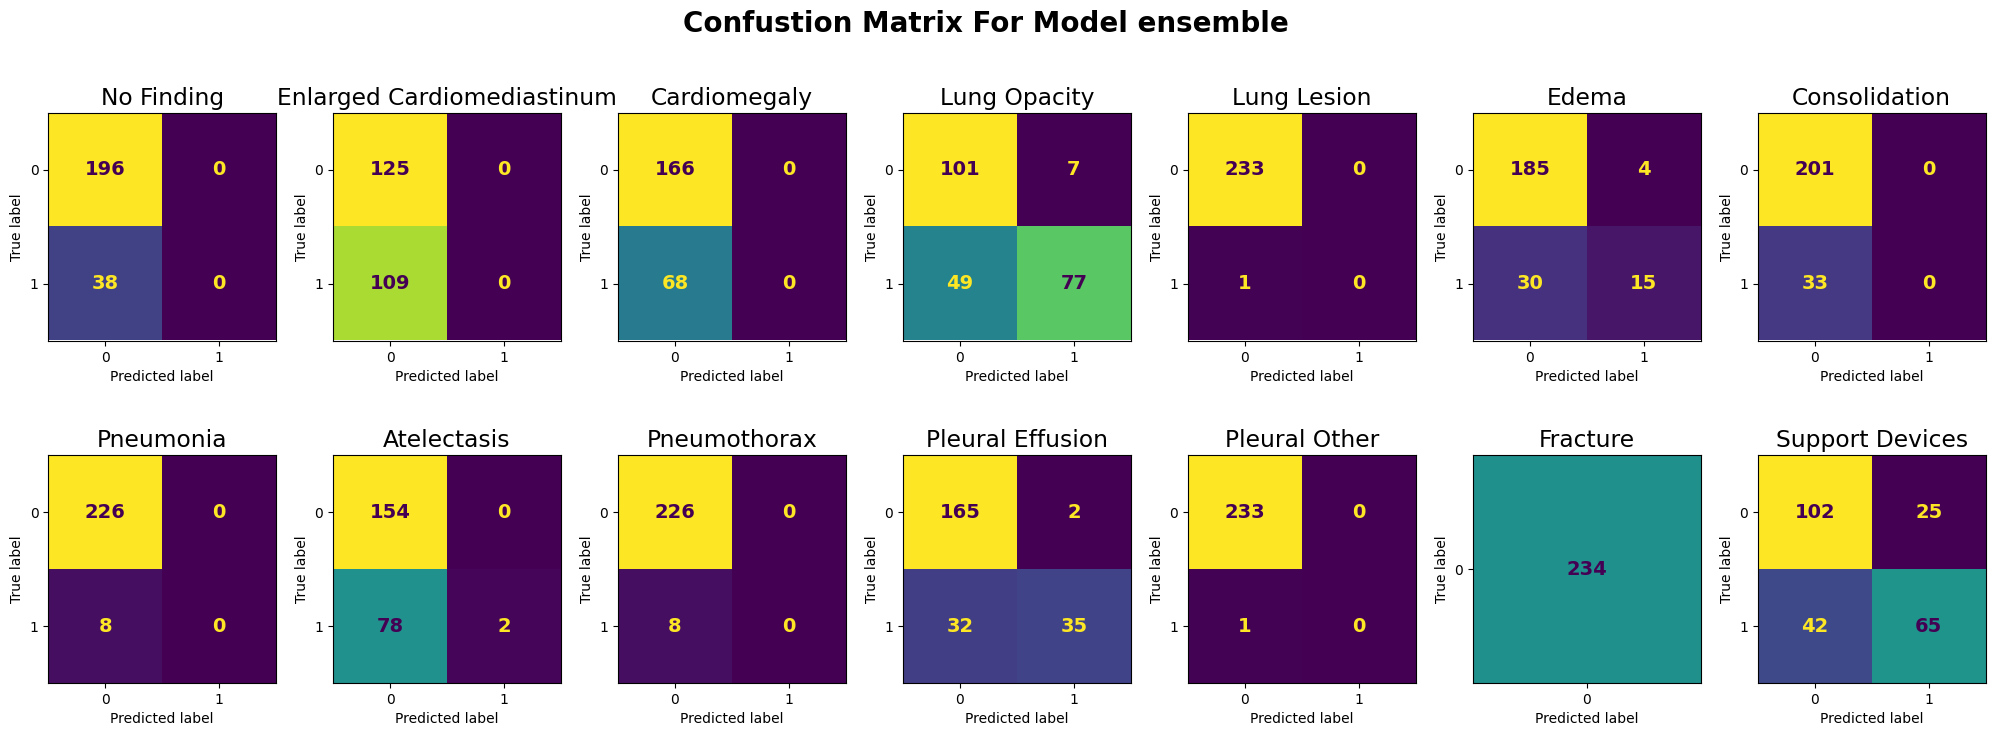

In [51]:
conf_all = pd.DataFrame()
for mName in mName_list[0:1]:
    mName = 'ensemble'
    print("Plot Confusion Matrix for Model ",mName)
    plot_conf(globals()[f"y_test_t_{mName}"],globals()[f"y_pred_t_{mName}"],mName)

In [52]:
print("All Done")

All Done
